How Soft Clustering for HDBSCAN Works
====================

This is a general description of how the soft clustering algorithm for HDBSCAN Works. We will implement soft clustering from scratch -- not in the efficient way that the [hdbscan library](https://github.com/scikit-learn-contrib/hdbscan) implements it, but in a way that makes it clearer what is actually going on.

What is Soft Clustering?
----------------------

To start, we'll provide a quick primer on what soft clustering is, and why you might want it in the first place. Traditional clustering assigns each point in a data set to a cluster (or to noise). This is a hard assignment; there are no mixed memberships. A point near the edge of one cluster and also close to a second cluster, is just as much "in the first cluster" as a point solidly in the center that is very distant from the second cluster. Equally, if the clustering algorithm supports noise assignments, then points are simply assigned as "noise". We are left with no idea as to which, if any cluster, they might have just missed the cur on being in.

The remedy for this is 'soft clustering' or 'fuzzy clustering'. In this approach points are no assigned cluster labels, but are instead assigned a vector of probabilities. The length of the vector is equal to the number of clusters found. The probability value at the $i$th entry of the vector is the probability that that point is a member of the $i$th cluster. This allows points to potentially be a mix of clusters. By looking at the vector a data scientist can discern how strongly a point is in a cluster, and which other clusters it is related to. Equally noise point will usually be assigned low probabilities of being in any cluster, but you can discern which clusters they are closer to, or even if they were very nearly part of a cluster. This is a much richer and more informative clustering result ... so how do we get it?

Soft Clustering for HDBSCAN
-------------------------

We want to produce a method of providing a soft membership vector for a given point across the selected clusters of a clustering. Ideally we want this to be interpretable as a probability of being a member of that cluster. For now we will work solely with categorizing points already in the clustered data set, but in principle this can be extended to new previously unseen points presuming we have a method to insert such points into the condensed tree (see other discussions on how to handle "prediction"). First let's get some test data, and an associated clustering so we have some idea of what we're working with in our test example.

In [18]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl

from scipy.spatial.distance import cdist

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

plot_kwds={'alpha':0.25, 's':60, 'linewidths':0}
palette = sns.color_palette('deep', 12)


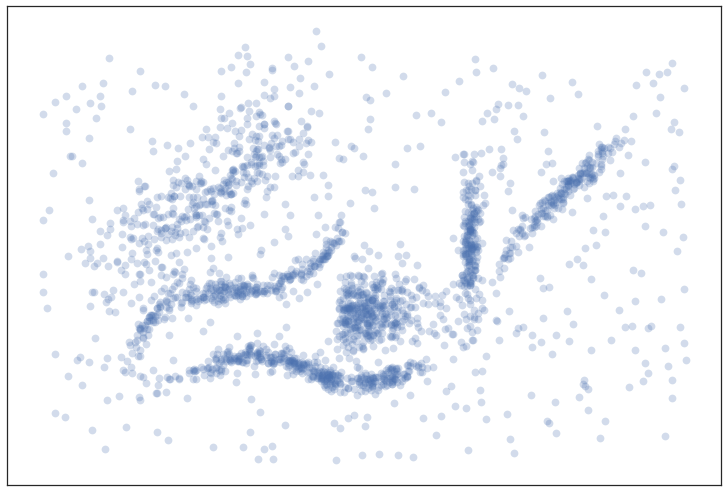

In [19]:
data = np.load('clusterable_data.npy')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(data.T[0], data.T[1], **plot_kwds)
ax.set_xticks([])
ax.set_yticks([]);

Now let's build a clusterer and fit it to this data.

In [20]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(data)

We can visualize the resulting clustering (using the soft cluster scores to vary the saturation so that we gain some intuition about how soft the clusters may be) to get an idea of what we are looking at:

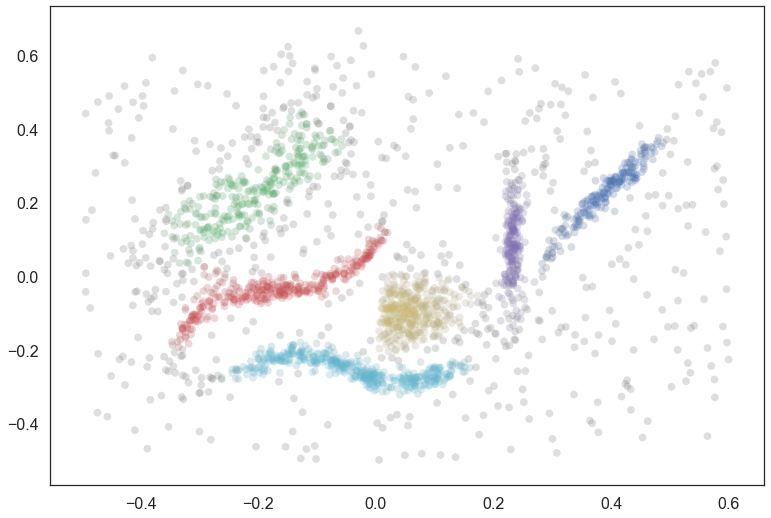

In [21]:
pal = sns.color_palette('deep', 8)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_, 
                                                            clusterer.probabilities_)]
plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds);

Suppose now that we have a data point and we want to get a notion of how close it is to each of the clusters. There are at least two ways we can thing about this. The first approach is to take the question somewhat literally and consider the distance from the cluster. As can be seen in our example, however, clusters need not have clear centers (they may be linear, or oddly shaped); even if we get a notion of distance it may not follow the "cluster manifold distance" and hence may be somewhat less than ideal. The second way of looking at things is to consider how much of an outlier the point is relative to each cluster -- using something akin to the outlier scores from GLOSH. The advantage of this approach is that it handles odd shaped clusters (even toroidal clusters) far better since it will explciitly follow the manifolds of the clusters. The down side of the outlier approach is that many points will all be equally "outlying", particularly noise points. Our goal is to fuse these two ideas.

Distance Based Membership
-------------------------

First we'll build a vector for a purely distance based vector of possible cluster membership -- essentially just asking "which cluster am I closest to?". To start this process we need some notion of exemplar point for each cluster to measure distance to. This is tricky since our clusters may have off shapes. In practice there isn't really any single clear exemplar for a cluster. The right solution, then, is to have a set of exemplar points for each cluster? How do we determine which points those should be? They should be the points that persist in the the cluster (and it's children in the HDBSCAN condensed tree) for the longest range of lambda values -- such points represent the "heart" of the cluster around which the ultimate cluster forms.

In practice we want to be careful and get the most persistent points in each leaf cluster beneath the cluster we are considering. This is because as a oddly shaped cluster breaks down it will split into subclusters. We don't want simply the most persistent of those subclusters, but rather representatives of each subcluster.

We can write this as a simple function to generate exemplar points. We work through the condensed tree, get the leaf clusters beneath a given cluster, and then find the points with maximum lambda value in that leaf. If we combine all those points together we get "exemplars".

In [22]:
def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
        points = raw_tree['child'][(raw_tree['parent'] == leaf) & 
                                   (raw_tree['lambda_val'] == max_lambda)]
        result = np.hstack((result, points))
    return result.astype(np.int)

We can plot the exemplars so you can get a sense of what points are being pulled out as exemplars for each cluster. First we plot all the data in gray, and then plot the exemplars for each cluster over the top, following the coloring used in the plot of the clusters above.

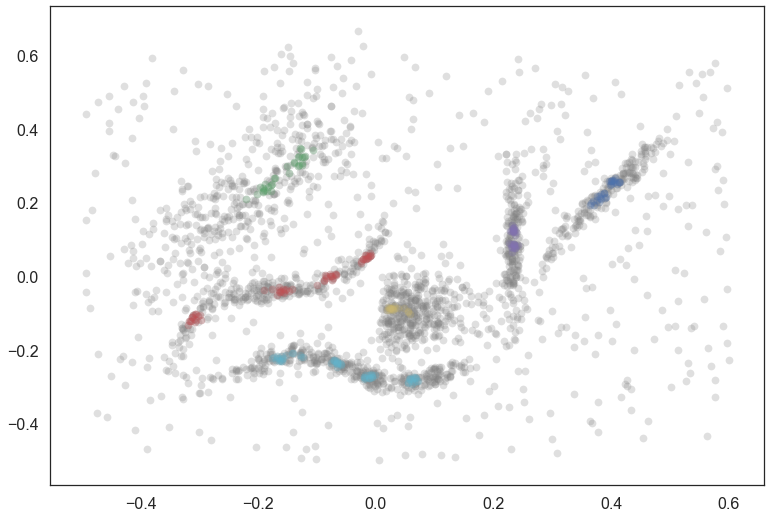

In [23]:
tree = clusterer.condensed_tree_
plt.scatter(data.T[0], data.T[1], c='grey', **plot_kwds)
for i, c in enumerate(tree._select_clusters()):
    c_exemplars = exemplars(c, tree)
    plt.scatter(data.T[0][c_exemplars], data.T[1][c_exemplars], c=palette[i], **plot_kwds)

You can see the several leaves in action here, with the red and cyan clusters having several subclusters streched along their length.

Now to compute a cluster membership score for a point we need to simply compute the distance to each of the cluster exemplar sets and scale membership scores accordingly. In practice we work with the inverse distance (just as HDBCSAN handles things with lambda values in the tree). Whether we do a softmax or simply normalize by dividing by the sum is "to be determined" as there isn't necessarily a clear answer. We'll leave it as an option in the code.

In [24]:
def min_dist_to_exemplar(point, cluster_exemplars, data):
    dists = cdist([data[point]], data[cluster_exemplars.astype(np.int32)])
    return dists.min()

def dist_vector(point, exemplar_dict, data):
    result = {}
    for cluster in exemplar_dict:
        result[cluster] = min_dist_to_exemplar(point, exemplar_dict[cluster], data)
    return np.array(list(result.values()))
    
def dist_membership_vector(point, exemplar_dict, data, softmax=False):
    if softmax:
        result = np.exp(1./dist_vector(point, exemplar_dict, data))
        result[~np.isfinite(result)] = np.finfo(np.double).max
    else:
        result = 1./dist_vector(point, exemplar_dict, data)
        result[~np.isfinite(result)] = np.finfo(np.double).max
    result /= result.sum()
    return result

We can get some sense of what this is doing by assigning every point to a cluster via the membership vector, and desaturating according to the strength of membership.

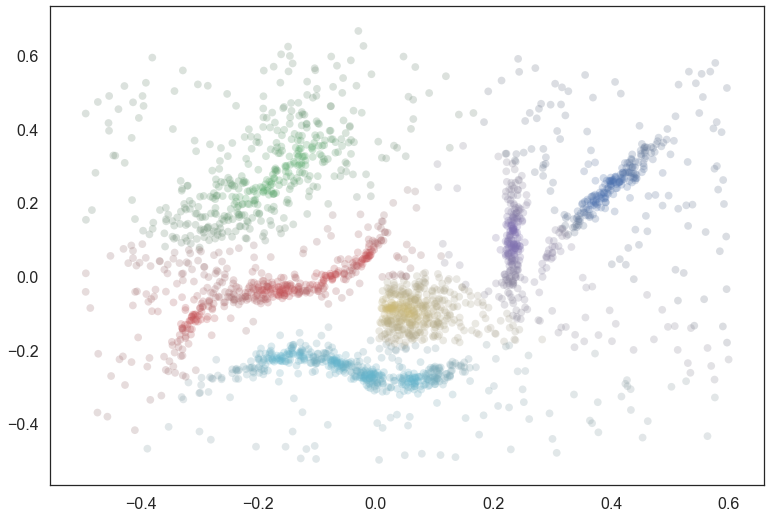

In [25]:
exemplar_dict = {c:exemplars(c,tree) for c in tree._select_clusters()}
colors = np.empty((data.shape[0], 3))
for x in range(data.shape[0]):
    membership_vector = dist_membership_vector(x, exemplar_dict, data)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds);

As you can see this is something that is a step in the right direction, but we are not following the manifold well. For example there is spill over between the cyan and yellow clusters, the red and yellow clusters, the red and green clusters, and the purple and blue clusters in a way that is not really ideal. This is because we are using pure distance (rather than any sort of cluster/manifold/density aware distance) and latching on to whatever is closest. What we need is an approach the understands the cluster structure better -- something based off the the actual structure (and lambda values therein) of the consdensed tree. This is exactly the sort of approach something based on outlier scores can provide.

Outlier Based Membership
------------------------

We want a notion of membership that follows the density based notions upon which the clustering is actually built. This is actually not too hard to arrange via a modification of the GLOSH algorithm for providing outlier scores. In that algorithm, given a point, we find the closest cluster in the condensed tree and then compare how long the point stayed in that cluster to the total persistence of the heart of the cluster. If we modify this to instead find the merge height of the point with a fixed cluster and then perform the same comparison of the points membership persistence with the maximum persistence of the cluster we can get a measure of how much of an outlier the point is *relative to the fixed cluster*. If we perform this calculation for each of the clusters we can get a vector of outlier scores. We can then normalize that (again, whether by softmax, or simply divide by the sum) to get a cluster membership vector.

To start we'll need some utility functions. These are far from the most efficient way to do this (in terms of compute time) but they demonstrate what is going on more clearly.

In [26]:
def max_lambda_val(cluster, tree):
    cluster_tree = tree[tree['child_size'] > 1]
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster)
    max_lambda = 0.0
    for leaf in leaves:
        max_lambda = max(max_lambda, 
                         tree['lambda_val'][tree['parent'] == leaf].max())
    return max_lambda

def points_in_cluster(cluster, tree):
    leaves = hdbscan.plots._recurse_leaf_dfs(tree, cluster)
    return leaves

Next we'll need a function to find the merge height. We'll presume we've used the above functions to precompute a dict of points for every cluster in our cluster tree.

In [27]:
def merge_height(point, cluster, tree, point_dict):
    cluster_row = tree[tree['child'] == cluster]
    cluster_height = cluster_row['lambda_val'][0]
    if point in point_dict[cluster]:
        merge_row = tree[tree['child'] == float(point)][0]
        return merge_row['lambda_val']
    else:
        while point not in point_dict[cluster]:
            parent_row = tree[tree['child'] == cluster]
            cluster = parent_row['parent'].astype(np.float64)[0]
        for row in tree[tree['parent'] == cluster]:
            child_cluster = float(row['child'])
            if child_cluster == point:
                return row['lambda_val']
            if child_cluster in point_dict and point in point_dict[child_cluster]:
                return row['lambda_val']

Now we can create a scoring function, providing an outlier score relative to each cluster. Now we'll assume we have a precomputed dict of maximum lambda values for each cluster, and a precomputed list of cluster_ids.

In [28]:
def per_cluster_scores(point, cluster_ids, tree, max_lambda_dict, point_dict):
    result = {}
    point_row = tree[tree['child'] == point]
    point_cluster = float(point_row[0]['parent'])
    max_lambda = max_lambda_dict[point_cluster] + 1e-8 # avoid zero lambda vals in odd cases
    
    for c in cluster_ids:
        height = merge_height(point, c, tree, point_dict)
        result[c] = (max_lambda / (max_lambda - height))
    return result

Finally we can write our function to provide an outlier based membership vector, leaving an option for using softmax instead of straightforward normalization.

In [29]:
def outlier_membership_vector(point, cluster_ids, tree, 
                              max_lambda_dict, point_dict, softmax=True):
    if softmax:
        result = np.exp(np.array(list(per_cluster_scores(point, 
                                                         cluster_ids, 
                                                         tree,
                                                         max_lambda_dict,
                                                         point_dict
                                                        ).values())))
        result[~np.isfinite(result)] = np.finfo(np.double).max
    else:
        result = np.array(list(per_cluster_scores(point, 
                                                  cluster_ids, 
                                                  tree,
                                                  max_lambda_dict,
                                                  point_dict
                                                 ).values()))
    result /= result.sum()
    return result

We can apply the same approach as before to get a general notion of what this approach has done for us, coloring points by the most likely cluster and then desaturating accoding to the actual membership strength.

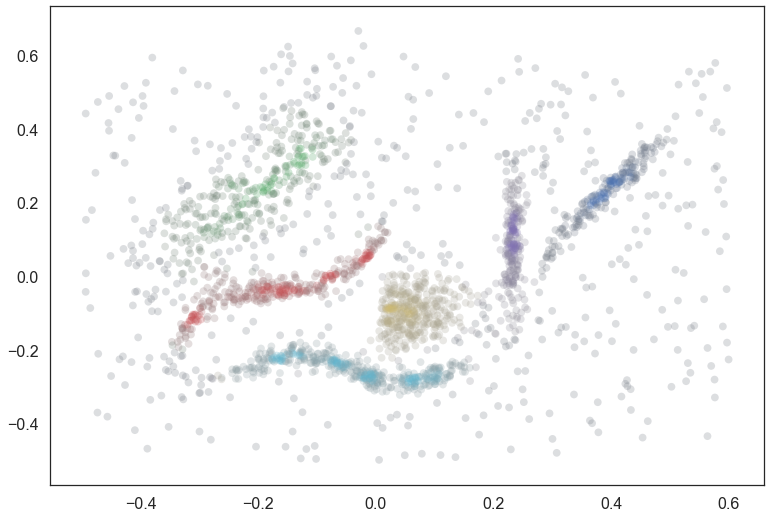

In [30]:
cluster_ids = tree._select_clusters()
raw_tree = tree._raw_tree
all_possible_clusters = np.arange(data.shape[0], raw_tree['parent'].max() + 1).astype(np.float64)
max_lambda_dict = {c:max_lambda_val(c, raw_tree) for c in all_possible_clusters}
point_dict = {c:set(points_in_cluster(c, raw_tree)) for c in all_possible_clusters}
colors = np.empty((data.shape[0], 3))
for x in range(data.shape[0]):
    membership_vector = outlier_membership_vector(x, cluster_ids, raw_tree, 
                                                  max_lambda_dict, point_dict, False)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds);

We see that we follow the clusters much better with this approach, but now everything is somewhat desaturated, and there are many points, even points quite close to one cluster (and far from others) that are pure gray. Thus while we follow the clusters well we've lost a certain amount of locality information since at certain distance scales many points join/leave a cluster at the same time, so they all get the same relative score across clusters. The ideal would be to combine the two sets of information that we have -- the cluster oriented and the locality oriented. That is the middle way which we will pursue.

The Middle Way
--------------

We need a way to combine these two approaches. The first point to note is that we can view the resulting membership vectors as probability mass functions for the probability that the point is a member of each cluster. Given two observations of PMFs the natural approach is simply to combine them via Bayes' to get a new posterior distribution. This is easy enough to arrange.

In [31]:
def combined_membership_vector(point, data, tree, exemplar_dict, cluster_ids,
                               max_lambda_dict, point_dict, softmax=False):
    raw_tree = tree._raw_tree
    dist_vec = dist_membership_vector(point, exemplar_dict, data, softmax)
    outl_vec = outlier_membership_vector(point, cluster_ids, raw_tree, 
                                         max_lambda_dict, point_dict, softmax)
    result = dist_vec * outl_vec
    result /= result.sum()
    return result

Again we can have some manner of window on the results by plotting points colored and desaturated according to the most likely cluster and the probability that the point is "in" that cluster.

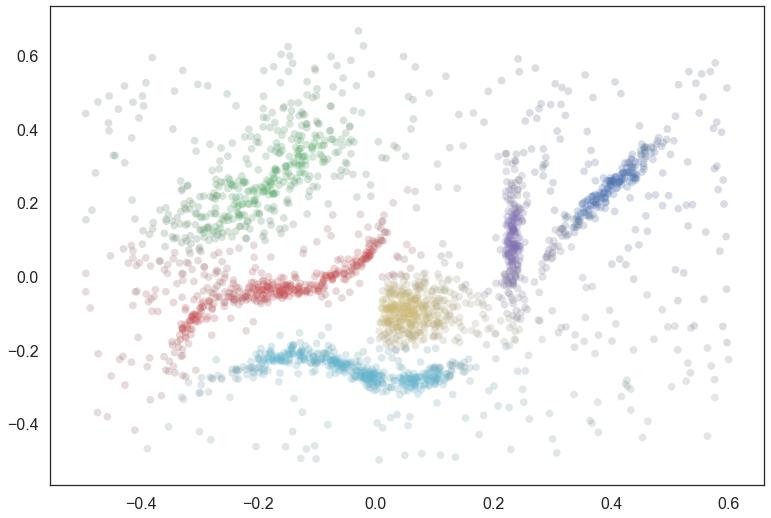

In [32]:
colors = np.empty((data.shape[0], 3))
for x in range(data.shape[0]):
    membership_vector = combined_membership_vector(x, data, tree, exemplar_dict, cluster_ids,
                                                   max_lambda_dict, point_dict, False)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds);

This looks a lot closer to what we had in mind -- We have cluster membership following manifolds, and noise points near clusters taking on some shades of the appropriate hue. Our one remaining problem is related to the noise points -- they are unlikely to be in any cluster, not merely a smear across the probabilities of being in any particular cluster.

Converting a Conditional Probability
------------------------------------

What we have computed so far is a probability vector that a point is in each cluster conditional on the point being in a cluster (since the sum of the vector is one, implying that, with probability one the point is in some cluster). We wish to convert this to a vector of probabilities with no such conditional. We can convert the conditional to the joint probability easily

$$P(x\in C_i | \exists j : x \in C_j) \cdot P(\exists j : x\in C_j) = P(x\in C_i , \exists j : x \in C_j)$$

But then we just note that

$$ P(x\in C_i , \exists j : x \in C_j) = P(x\in C_i)$$

since $P(\exists j : x \in C_j) = 1$ whenever $x\in C_i$. We then only need to estimate $P(\exists j : x\in C_j)$, and we can do that by simply comparing the merge height to the nearest cluster with the maximum lambda of that cluster.

In [33]:
def prob_in_some_cluster(point, tree, cluster_ids, point_dict, max_lambda_dict):
    heights = []
    for cluster in cluster_ids:
        heights.append(merge_height(point, cluster, tree._raw_tree, point_dict))
    height = max(heights)
    nearest_cluster = cluster_ids[np.argmax(heights)]
    max_lambda = max_lambda_dict[nearest_cluster]
    return height / max_lambda

The result is that we merely need to multiply our combined membership vector to get a vector of probabilities of being in a cluster. We can visualize the results again.

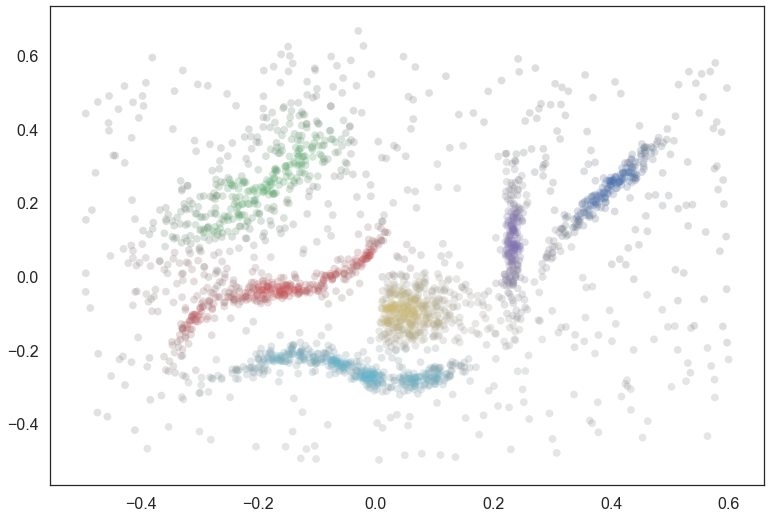

In [34]:
colors = np.empty((data.shape[0], 3))
for x in range(data.shape[0]):
    membership_vector = combined_membership_vector(x, data, tree, exemplar_dict, cluster_ids,
                                                   max_lambda_dict, point_dict, False)
    membership_vector *= prob_in_some_cluster(x, tree, cluster_ids, point_dict, max_lambda_dict)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds);

And there we have the result!